# `CLOUD.jl` - 2D linear advection example

In [1]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1664


## Define the physical problem

In [2]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period
CFL = 0.1

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataSine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters (energy-conservative scheme)

In [3]:
M = 4
p = 4
form = WeakConservationForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))
ode_algorithm = CarpenterKennedy2N54();

## Set up a `NodalTensor` scheme on quadrilaterals of degree `p` with `M` edges in each direction

In [4]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Quad(), mapping_degree=p)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.2)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
    "results/advection_2d/", overwrite=true, clear=true);

## Run the solver

In [5]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T))

h = L/sqrt(reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*10))))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            8.21s /  17.8%           3.01GiB /  20.7%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         22.8k    1.41s   96.6%  61.9μs    617MiB   96.6%  27.7KiB
   apply operators      22.8k    1.03s   70.5%  45.2μs    391MiB   61.3%  17.5KiB
     volume terms       22.8k    558ms   38.1%  24.4μs    241MiB   37.8%  10.8KiB
     mul test function  22.8k    238ms   16.2%  10.4μs   91.7MiB   14.4%  4.11KiB
     facet terms        22.8k   99.3ms    6.8%  4.35μs   23.1MiB    3.6%  1.04KiB
     mass matrix solve  22.8k   11.7ms    0.8%   512ns   1.60MiB    0.3%    73.3B
   eval nodal s

## Calculate the integral L<sup>2</sup> error norm

In [6]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.07575411152263535


## Analyze conservation and energy dissipation

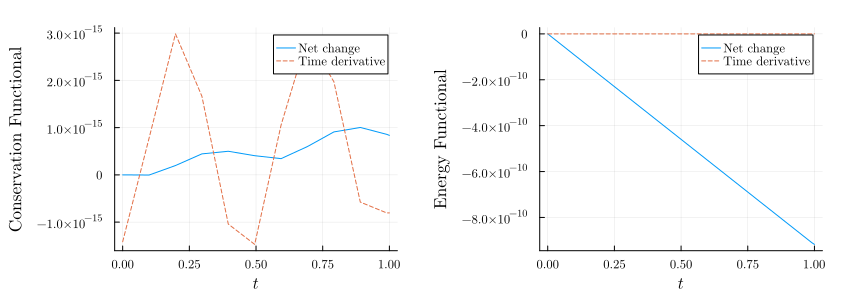

In [7]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional")
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional")
plot(p1,p2, size=(850,300),margin=5mm)

## Postprocess for VTK visualization

In [8]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));